# Anwendung von maschinellem Lernen auf den KHK_Klassifikation.csv Datensatz

## Praktische Demonstration für verschiedene machine Learning Modelle

### Tim Bleicher, Linus Pfeifer

Dieses Jupyter Notebook demonstriert die Anwendung von verschiedenen Machine Learning Modellen auf den KHK_Klassifikation.csv Datensatz. 

**Inhaltsverzeichnis:**
TODO

## 1. Einbindung der Daten

Zu beginn des Projekts werden die Daten zunächst geladen um diese im anschluss analysieren und nutzen zu können.

In [108]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

In [110]:
data = pd.read_csv('KHK_Klassifikation.csv', sep=',')

In [111]:
print(data.head())

   Alter Geschlecht  Blutdruck  Chol  Blutzucker     EKG  HFmax AP   RZ  KHK
0     40          M        140   289           0  Normal    172  N  0.0    0
1     49          F        160   180           0  Normal    156  N  1.0    1
2     37          M        130   283           0      ST     98  N  0.0    0
3     48          F        138   214           0  Normal    108  Y  1.5    1
4     54          M        150   195           0  Normal    122  N  0.0    0


## 1.1 explorative Analyse der Daten 

Die explorative Datenanalyse (EDA) ist ein Ansatz zur Untersuchung von Datensätzen, bei dem zunächst deren Hauptmerkmale visuell und statistisch beschrieben werden – oft noch ohne eine konkrete Hypothese. Ziel ist es, ein erstes Verständnis für Struktur, Muster, Ausreißer, Verteilungen und potenzielle Zusammenhänge in den Daten zu bekommen (vgl. https://www.ibm.com/think/topics/exploratory-data-analysis).

### 📄 Beschreibung der Attribute im Datensatz

| Attribut      | Beschreibung |
|---------------|-------------|
| **Alter** | Alter der Patientin oder des Patienten in Jahren. |
| **Geschlecht** | Geschlecht der Person: <br>`M` steht für männlich, `F` für weiblich. |
| **Blutdruck** | Systolischer Blutdruck in mmHg (Millimeter Quecksilbersäule), gemessen im Ruhezustand. Werte ab 140 gelten in der Regel als erhöhter Blutdruck. (vgl. https://www.visomat.de/blutdruck-normalwerte/)|
| **Chol** | Gesamtcholesterin im Blut in mg/dL (Milligramm pro Deziliter). Erhöhte Werte (>190 mg/dL) können ein Risiko für Herz-Kreislauf-Erkrankungen darstellen. (vgl. https://www.cholesterinspiegel.de/auffaellige-cholesterinwerte/) |
| **Blutzucker** | Nüchtern-Blutzuckerwert: <br>`0` = Normaler Blutzucker <br>`1` = Erhöhter Blutzucker (möglicher Hinweis auf Diabetes oder Prädiabetes). |
| **EKG** | Ergebnis des Ruhe-EKGs. Mögliche Kategorien: <br>- `Normal` = unauffälliger Befund <br>- `ST` = ST-Streckensenkung (Hinweis auf Belastungsischämie) <br>- `LVH` = Linksventrikuläre Hypertrophie (Herzmuskelvergrößerung). |
| **HFmax** | Maximale Herzfrequenz (in Schlägen pro Minute), die während eines Belastungstests erreicht wurde. Sehr grobe Faustregel: HFmax = 220 - Lebensalter (vgl. https://www.germanjournalsportsmedicine.com/archive/archive-2010/heft-12/die-maximale-herzfrequenz/) |
| **AP** | Angina Pectoris bei Belastung: <br>`N` = Keine Symptome <br>`Y` = Auftreten von Angina Pectoris (Brustschmerzen unter Belastung), möglicher Hinweis auf Durchblutungsstörungen des Herzens. |
| **RZ** | Rückgang (bzw. Veränderung) der ST-Strecke während eines Belastungs-EKGs in **mm**. <br> Positive Werte deuten auf eine **ST-Streckensenkung** hin, was auf eine mögliche **Ischämie des Herzmuskels** (z. B. bei KHK) hindeuten kann. <br> Negative Werte können als **ST-Streckenhebung** interpretiert werden – diese können je nach klinischem Zusammenhang normal, unspezifisch oder auch pathologisch sein (z. B. bei Infarkten oder Perikarditis). <br> In der Regel gilt: Je größer der **absolute Betrag**, desto auffälliger der Befund. |
| **KHK** | **Zielvariable** – Diagnose einer koronaren Herzkrankheit: <br>`0` = Keine KHK <br>`1` = KHK nachgewiesen (positives Ergebnis). |



,Alter,Geschlecht,Blutdruck,Chol,Blutzucker,EKG,HFmax,AP,RZ,KHK
0,40,M,140,289,0,Normal,172,N,0.0,0
1,49,F,160,180,0,Normal,156,N,1.0,1
2,37,M,130,283,0,ST,98,N,0.0,0
3,48,F,138,214,0,Normal,108,Y,1.5,1
4,54,M,150,195,0,Normal,122,N,0.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Alter       918 non-null    int64  
 1   Geschlecht  918 non-null    object 
 2   Blutdruck   918 non-null    int64  
 3   Chol        918 non-null    int64  
 4   Blutzucker  918 non-null    int64  
 5   EKG         918 non-null    object 
 6   HFmax       918 non-null    int64  
 7   AP          918 non-null    object 
 8   RZ          918 non-null    float64
 9   KHK         918 non-null    int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 71.8+ KB


None

,Alter,Blutdruck,Chol,Blutzucker,HFmax,RZ,KHK
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000



Wertverteilung für 'Geschlecht':
Geschlecht
M    725
F    193
Name: count, dtype: int64

Wertverteilung für 'EKG':
EKG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64

Wertverteilung für 'AP':
AP
N    547
Y    371
Name: count, dtype: int64

Fehlende Werte pro Spalte:
Alter         0
Geschlecht    0
Blutdruck     0
Chol          0
Blutzucker    0
EKG           0
HFmax         0
AP            0
RZ            0
KHK           0
dtype: int64

Anzahl doppelter Zeilen: 0

Verteilung der Zielvariable 'KHK':
KHK
1    508
0    410
Name: count, dtype: int64


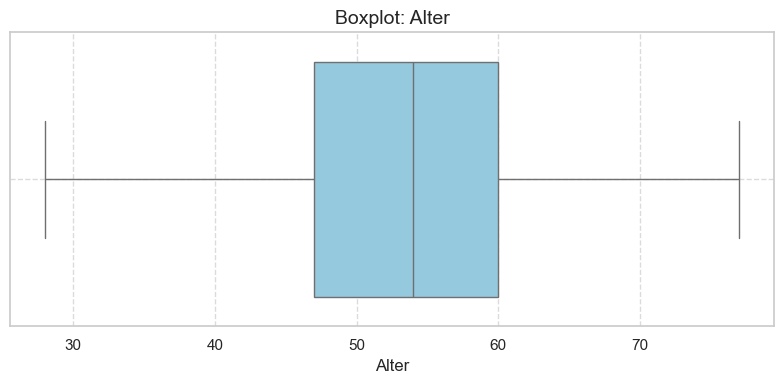

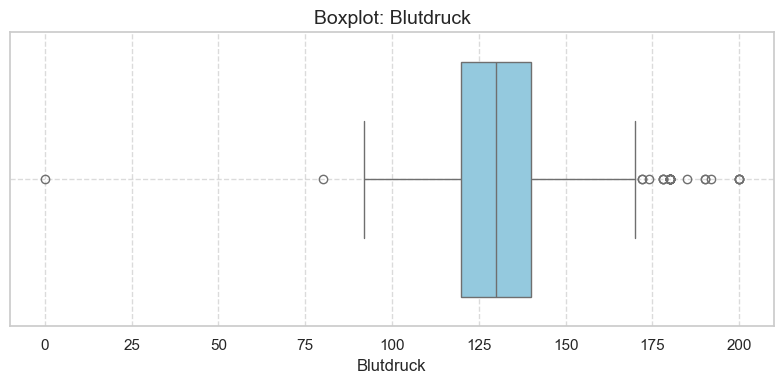

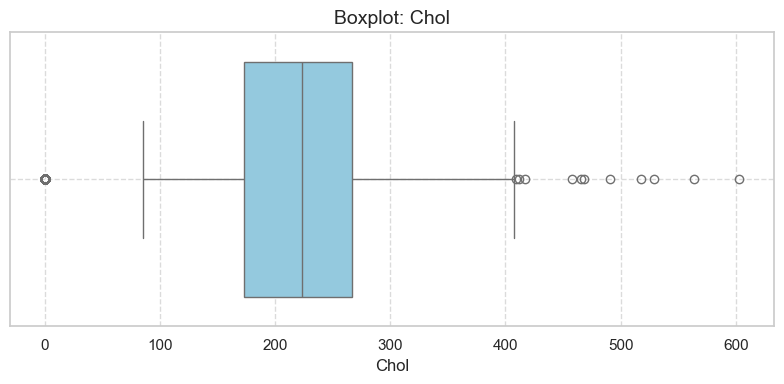

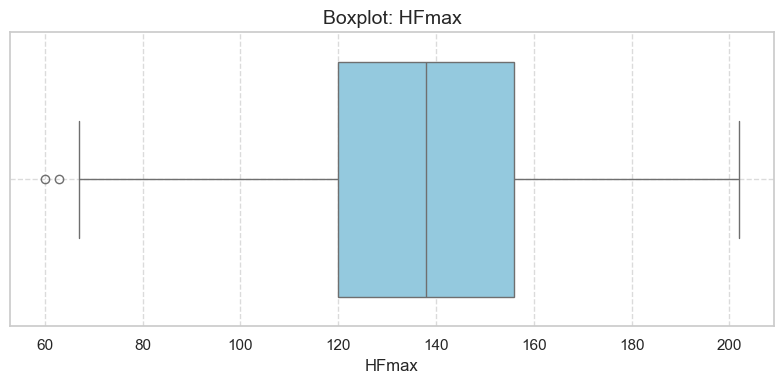

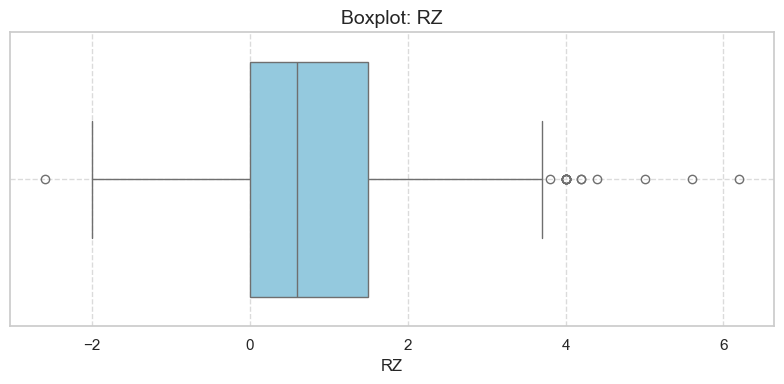

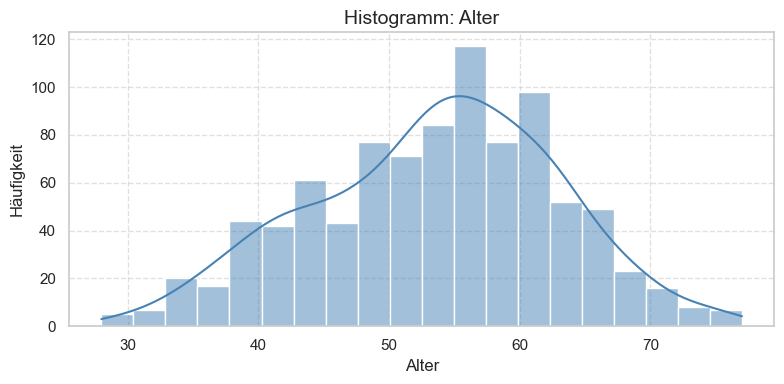

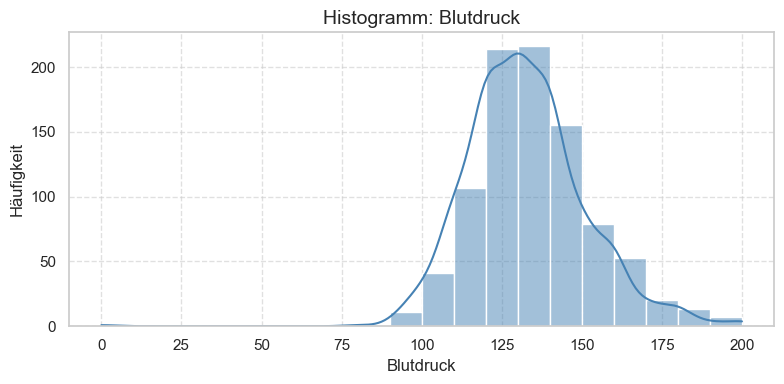

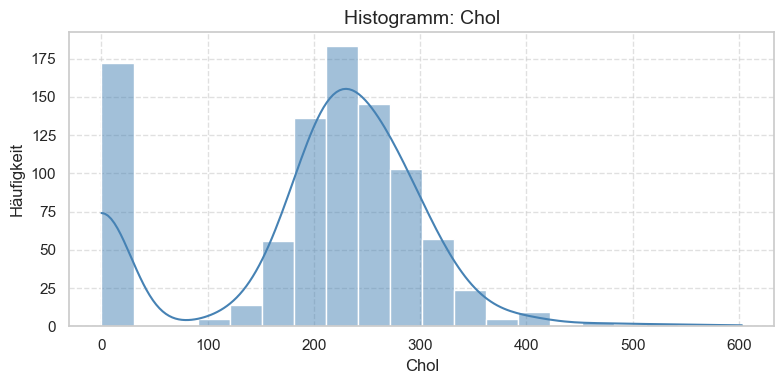

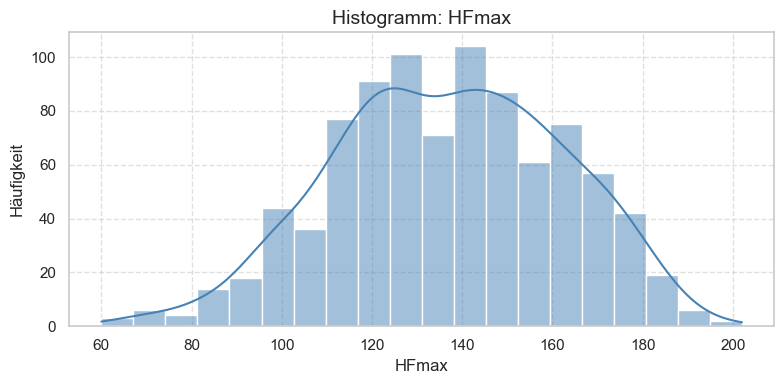

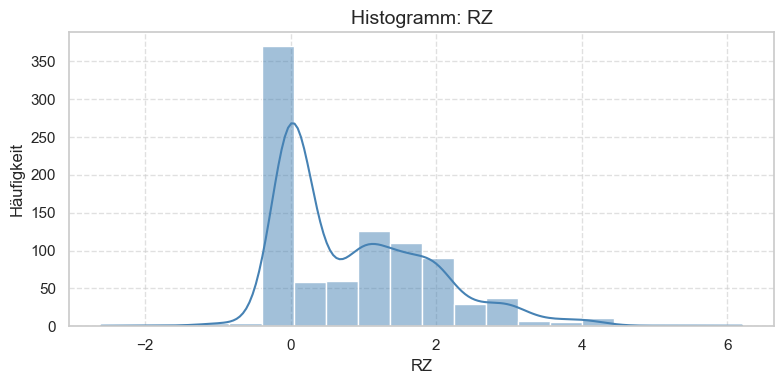

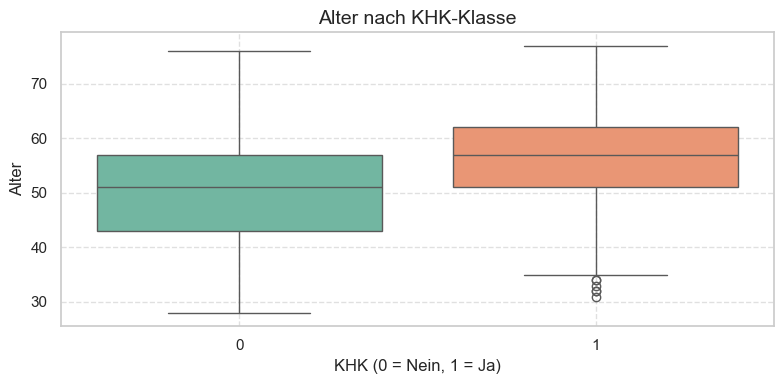

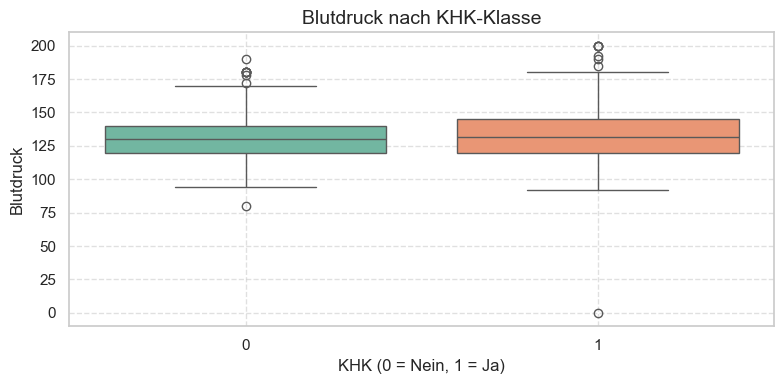

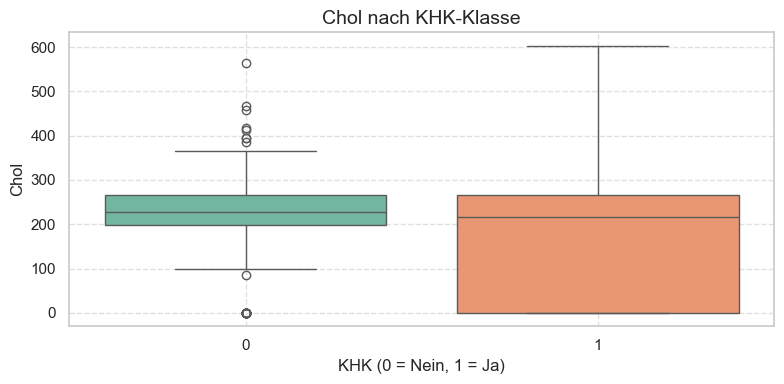

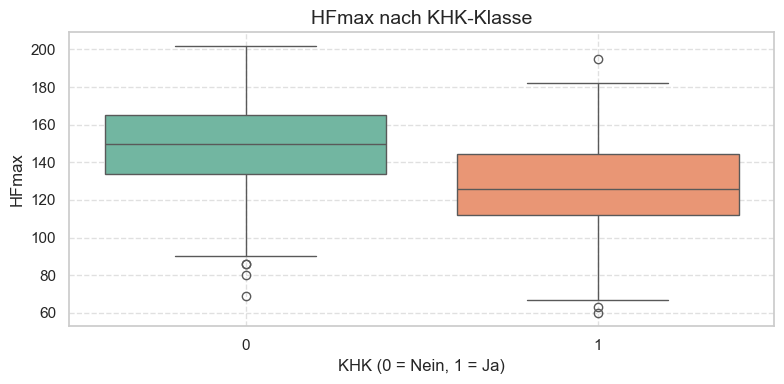

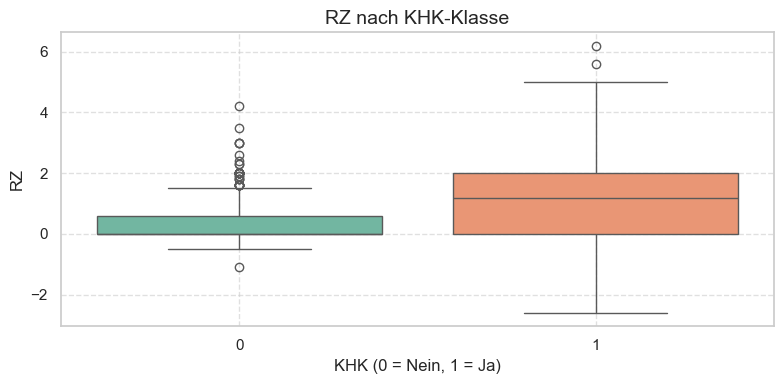


Daten nach Umkodierung:


,Alter,Geschlecht,Blutdruck,Chol,Blutzucker,HFmax,AP,RZ,KHK,EKG_Normal,EKG_ST
0,40,0,140,289,0,172,0,0.0,0,True,False
1,49,1,160,180,0,156,0,1.0,1,True,False
2,37,0,130,283,0,98,0,0.0,0,False,True
3,48,1,138,214,0,108,1,1.5,1,True,False
4,54,0,150,195,0,122,0,0.0,0,True,False


In [112]:
sns.set_theme(style="whitegrid")  # Einheitliches, sauberes Plot-Design

# ========================================
# 1. Daten laden und Überblick gewinnen
# ========================================

# Lade die Daten
df = data.copy()

# Zeige die ersten paar Zeilen
display(df.head())

# Allgemeine Infos über den Datensatz
display(df.info())

# Statistische Übersicht über numerische Merkmale
display(df.describe())

# Häufigkeit von Werten bei kategorialen Features
for col in df.select_dtypes(include=['object']).columns:
    print(f"\nWertverteilung für '{col}':")
    print(df[col].value_counts())

# Fehlende Werte
print("\nFehlende Werte pro Spalte:")
print(df.isnull().sum())

# Duplikate prüfen
print("\nAnzahl doppelter Zeilen:", df.duplicated().sum())

# Verteilung der Zielvariable (KHK)
print("\nVerteilung der Zielvariable 'KHK':")
print(df["KHK"].value_counts())

# ========================================
# 2. Visualisierung – Boxplots (nur sinnvolle numerische Spalten)
# ========================================

# Nur numerische Spalten
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Nur Spalten mit mehr als 2 einzigartigen Werten (also keine binären)
numerical_cols_filtered = [
    col for col in numerical_cols
    if df[col].nunique() > 2
]

for col in numerical_cols_filtered:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col, color="skyblue")
    plt.title(f"Boxplot: {col}", fontsize=14)
    plt.xlabel(col)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# ========================================
# 3. Visualisierung – Histogramme (nur für kontinuierliche Spalten)
# ========================================

for col in numerical_cols_filtered:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, kde=True, color="steelblue", bins=20)
    plt.title(f"Histogramm: {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Häufigkeit")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# ========================================
# 4. Vergleich nach KHK – Boxplots (ohne binäre Spalten wie Blutzucker)
# ========================================

numerical_cols_khk = [
    col for col in numerical_cols
    if df[col].nunique() > 2 and col != "KHK" and col != "Blutzucker"
]

for col in numerical_cols_khk:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x="KHK", y=col, hue="KHK", palette="Set2", legend=False)
    plt.title(f"{col} nach KHK-Klasse", fontsize=14)
    plt.xlabel("KHK (0 = Nein, 1 = Ja)")
    plt.ylabel(col)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# ========================================
# 5. Umwandlung der nicht-numerischen Werte
# ========================================

# Kopie des DataFrames für die Kodierung
df_encoded = df.copy()

# Binäre Umwandlung
df_encoded["Geschlecht"] = df_encoded["Geschlecht"].map({"M": 0, "F": 1})
df_encoded["AP"] = df_encoded["AP"].map({"N": 0, "Y": 1})

# One-Hot-Encoding für EKG
df_encoded = pd.get_dummies(df_encoded, columns=["EKG"], drop_first=True)

# Ergebnis anzeigen
print("\nDaten nach Umkodierung:")
display(df_encoded.head())

## 2. PCA-Dimensionsreduzierung zur Visualisierung und Analyse der Daten 

### Funktionsweise von PCA
Die Hauptkomponentenanalyse (PCA) dient der Dimensionsreduktion eines Datensatzes. Dies ermöglicht beispielsweise verschiedene Analyse des gesamten Datensatzes (mit mehr als 3 Dimensionen), wobei die Ergebnisse durch die Dimensionsreduktion weiterhin visualisiert werden können.
Das Verfahren der PCA läuft nach folgendem Schema ab:

1. Berechnung des Mittelwerts und Zentrierung der Daten
2. Berechnung der Kovarianzmatrix
3. Berechnung der Eigenwerte und Eigenvektoren
4. Transformation der Daten

Damit die PCA korrekt funktioniert, muss zunächst von jeder Dimension der Mittelwert subtrahiert werden. Dieser Mittelwert entspricht dem Durchschnittswert jeder Dimension. Beispielsweise wird von allen $x$-Werten der Mittelwert $\overline{x}$ subtrahiert. Entsprechendes gilt für die anderen Dimensionen der Daten. Dadurch entsteht ein Datensatz mit einem Mittelwert von null.

Im nächsten Schritt wird die Kovarianzmatrix berechnet, welche die wechselseitigen Zusammenhänge zwischen den Merkmalen quantifiziert. Falls zwei Merkmale stark korrelieren, können diese in einer neuen Achse kombiniert werden.

Anschließend werden die Eigenwerte und Eigenvektoren der Kovarianzmatrix bestimmt. Die Eigenvektoren definieren die Richtungen der Hauptkomponenten, während die zugehörigen Eigenwerte die Bedeutung bzw. die Varianz der jeweiligen Eigenvektoren widerspiegeln.

Es folgt die eigentliche Dimensionsreduktion, indem nur diejenigen Eigenvektoren mit den größten Eigenwerten ausgewählt werden. Diese Eigenvektoren entsprechen den neuen Hauptachsen des Datensatzes.

Schließlich werden die Daten transformiert, indem die ursprüngliche Datenmatrix mit der Matrix der Eigenvektoren multipliziert wird. In dieser Matrix repräsentiert jede Spalte einen Eigenvektor.



In [113]:
label_encoder = LabelEncoder()
categorical_columns = ['Geschlecht', 'EKG', 'AP']
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

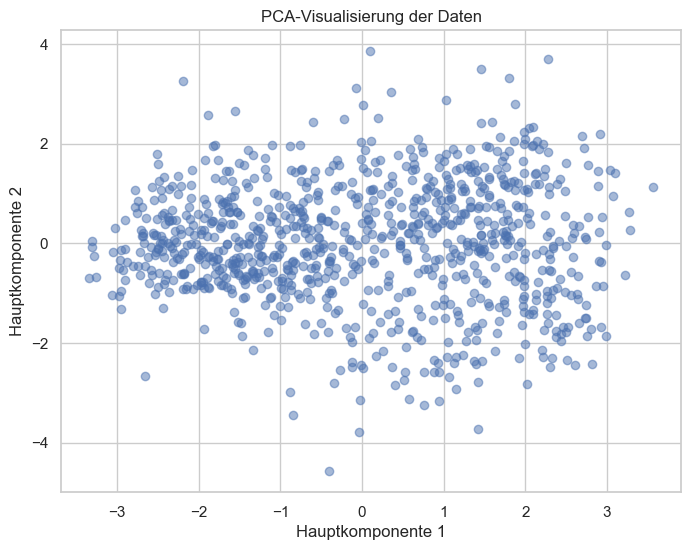

In [114]:
# Skalierung der Daten
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# PCA-Transformation mit zwei Hauptkomponenten
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

# Visualisierung der PCA-Ergebnisse
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.xlabel('Hauptkomponente 1')
plt.ylabel('Hauptkomponente 2')
plt.title('PCA-Visualisierung der Daten')
plt.grid(True)
plt.show()